In [6]:
from db.helpers import new_sales_collection
from db.queries import new_sales_refenrece_ids_with_sales_count
import pandas as pd
import random

In [7]:
def find_seg(data: list[dict], seg_len: int=3):
    seg = []
    for i in data:
        if i["Monthly_Sales"] == None and len(seg) > 0:
            seg.append(i)
        if i["Monthly_Sales"] != None and len(seg) == 0:
            seg.append(i)

        if i["Monthly_Sales"] != None and len(seg) > 0:
            if len(seg) == 1:
                seg.append(i)
            else:
                if len(seg) > seg_len:
                    seg = []
                    seg.append(i)
                    continue
                seg.append(i)
                yield seg
                seg = []

In [8]:
all_sales = list(new_sales_collection.aggregate(pipeline=[
    {
        '$match': {
            'Monthly_Sales': {
                '$ne': None
            }
        }
    }, {
        '$group': {
            '_id': '$Brand', 
            'generated': {
                '$push': {
                    '$cond': [
                        {
                            '$eq': [
                                '$Source', 'Generated'
                            ]
                        }, '$Monthly_Sales', None
                    ]
                }
            }, 
            'actual': {
                '$push': {
                    '$cond': [
                        {
                            '$ne': [
                                '$Source', 'Generated'
                            ]
                        }, '$Monthly_Sales', None
                    ]
                }
            }
        }
    }, {
        '$unwind': {
            'path': '$generated'
        }
    }, {
        '$unwind': {
            'path': '$actual'
        }
    }, {
        '$group': {
            '_id': '$_id', 
            'max_actual': {
                '$max': '$actual'
            }, 
            'min_actual': {
                '$min': '$actual'
            }, 
            'max_generated': {
                '$max': '$generated'
            }, 
            'min_generated': {
                '$min': '$generated'
            }
        }
    }, {
        '$match': {
            'max_actual': {
                '$ne': None
            }, 
            'max_generated': {
                '$ne': None
            }
        }
    } 
]))
df = pd.DataFrame(all_sales)

In [9]:
display(df)
display(df[df['max_generated'] > df['max_actual']])

,_id,max_actual,min_actual,max_generated,min_generated
0,Froyo,179008.0,5680.0,125414.000000,5320.000000
1,ananas,194092.0,15426.0,149014.000000,23767.900000
2,IPEKYOL,29730.0,9206.0,23183.200000,9704.800000
3,Home Center,383850.0,100190.0,102766.000000,95774.000000
4,The Comfort Shoe Co.,29184.0,3660.0,19811.466667,5773.090909
...,...,...,...,...,...
1074,Vaigai Boutique,34890.0,11890.0,21545.000000,14635.000000
1075,Dadas,18660.0,4450.0,14195.000000,10785.000000
1076,Masah,4106.0,1510.0,1692.533333,1439.466667
1077,Madame Coco,17720.0,11420.0,16200.000000,11400.000000


,_id,max_actual,min_actual,max_generated,min_generated


{'_id': 'Foodservice 3015', 'fieldN': 30}

'Generated'

79372.86956521738

'Actual'

85990.0

<Axes: xlabel='Sales_Period'>

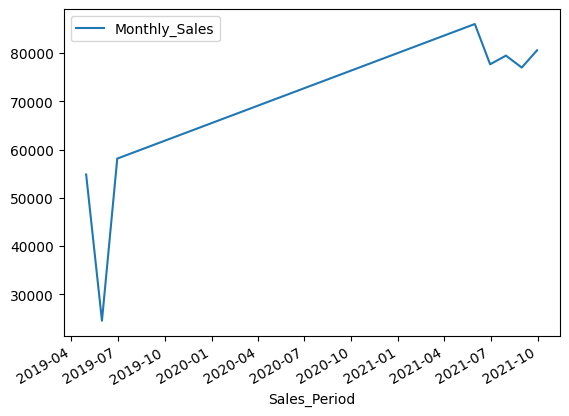

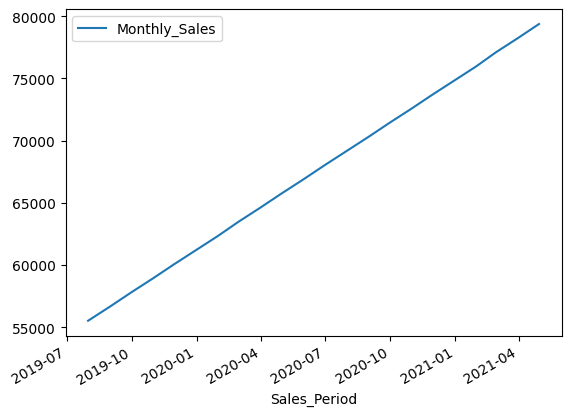

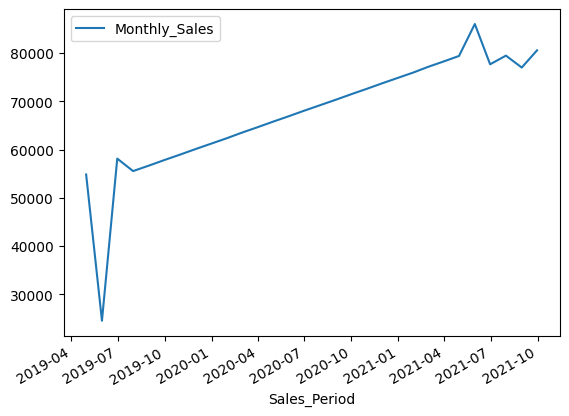

In [10]:
reference_ids = list(new_sales_refenrece_ids_with_sales_count()) 
id = random.choice(reference_ids) 
# id = {'_id': 'Retail 170023', 'fieldN': 36}
display(id)
sales = new_sales_collection.find({"Reference_Full_ID":id['_id']})
sales = list(sales)
sales = pd.DataFrame(sales)
generated_filter = (sales['Study'] == 'Generated') & (sales['Researcher'] == 'Mahmoud') &(sales['Source'] == 'Generated') & (sales['Monthly_Sales'].notna())
actual_filter =(sales['Study'] != 'generated')  & (sales['Source'] != 'Generated') & (sales['Monthly_Sales'].notna()) 
display('Generated',sales[generated_filter]['Monthly_Sales'].max())
display('Actual',sales[actual_filter]['Monthly_Sales'].max())
sales[sales['Source'] != 'Generated'].plot(x='Sales_Period',y='Monthly_Sales')
sales[sales['Source'] == 'Generated'].plot(x='Sales_Period',y='Monthly_Sales')
sales.plot(x='Sales_Period',y='Monthly_Sales')
# sales['Monthly_Sales'] = sales['Monthly_Sales'].interpolate(limit_area='inside')
# display(sales['Monthly_Sales'])
# sales.plot(x='Sales_Period',y='Monthly_Sales')

In [11]:
id = {'_id': 'Retail 170023', 'fieldN': 36}
display(id)
sales = new_sales_collection.find({"Reference_Full_ID":id['_id'],"Monthly_Sales":None})
df = pd.DataFrame(sales)
display(df.tail())

{'_id': 'Retail 170023', 'fieldN': 36}

,_id,Primary_ID,Primary_Sheet,Primary_Full_ID,Reference_ID,Reference_Sheet,Reference_Full_ID,Company_Name,Industry_Level_2,Product_Focus,...,Store_Opening_Year,Store_Closing_Day,Store_Closing_Month,Store_Closing_Year,Info_Date,Source,Study,Researcher,Sales_Month,Sales_Year
84,65a8e1f350a86658d34e17e7,383533,Sales,Sales 383533,170023,Retail,Retail 170023,0,Personal Care,Perfumes,...,0.0,0.0,0.0,0.0,2024-01-18 11:31:39.974,Generated,Generated,Mahmoud,12,2019
85,65a8e1f350a86658d34e17f3,383545,Sales,Sales 383545,170023,Retail,Retail 170023,0,Personal Care,Perfumes,...,0.0,0.0,0.0,0.0,2024-01-18 11:31:39.975,Generated,Generated,Mahmoud,12,2020
86,65a8e1f350a86658d34e17ff,383557,Sales,Sales 383557,170023,Retail,Retail 170023,0,Personal Care,Perfumes,...,0.0,0.0,0.0,0.0,2024-01-18 11:31:39.975,Generated,Generated,Mahmoud,12,2021
87,65a8e1f350a86658d34e180b,383569,Sales,Sales 383569,170023,Retail,Retail 170023,0,Personal Care,Perfumes,...,0.0,0.0,0.0,0.0,2024-01-18 11:31:39.976,Generated,Generated,Mahmoud,12,2022
88,65a8e1f350a86658d34e1817,383581,Sales,Sales 383581,170023,Retail,Retail 170023,0,Personal Care,Perfumes,...,0.0,0.0,0.0,0.0,2024-01-18 11:31:39.976,Generated,Generated,Mahmoud,12,2023


In [12]:
df = pd.read_csv('./output/method_1.csv')

10511


73369.8943939737

,RID,MONTH,YEAR,Store Opening Month,Store Opening Year,Store Closing Month,Store Closing Year,Weekday Store Sales,Weekday Delivery Sales,Weekend Store Sales,Weekend Delivery Sales,original,Weekday Total Sales,Weekend Total Sales,Monthly Store Sales,Monthly Delivery Sales,Monthly Sales,Sales_Period
count,73.0,73.000000,73.000000,73.0,73.0,73.0,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,7.300000e+01,73.000000,7.300000e+01,73
mean,10511.0,6.424658,2020.547945,0.0,0.0,0.0,0.0,30829.166878,711.413979,485.643836,711.413979,0.068493,31540.580857,1197.057814,6.204685e+05,19919.591402,6.403881e+05,2020-12-30 20:42:44.383561728
min,10511.0,1.000000,2018.000000,0.0,0.0,0.0,0.0,120.006760,0.439643,359.000000,0.439643,0.000000,282.291458,485.439643,6.280135e+03,12.309999,1.082411e+04,2018-01-01 00:00:00
25%,10511.0,3.000000,2019.000000,0.0,0.0,0.0,0.0,553.057090,387.502718,485.000000,387.502718,0.000000,1063.443432,865.706445,1.494114e+04,10850.076109,2.905035e+04,2019-07-01 00:00:00
50%,10511.0,6.000000,2021.000000,0.0,0.0,0.0,0.0,2679.572677,484.240030,485.000000,484.240030,0.000000,3319.493632,969.240030,5.747145e+04,13558.720849,7.336989e+04,2021-01-01 00:00:00
75%,10511.0,9.000000,2022.000000,0.0,0.0,0.0,0.0,10570.842260,710.875061,485.000000,710.875061,0.000000,11938.459489,1195.875061,2.152968e+05,19904.501695,2.511019e+05,2022-07-01 00:00:00
max,10511.0,12.000000,2024.000000,0.0,0.0,0.0,0.0,512577.610780,4450.098071,830.000000,4450.098071,1.000000,512993.747102,4935.098071,1.025543e+07,124602.745999,1.026708e+07,2024-01-01 00:00:00
std,0.0,3.511560,1.756267,0.0,0.0,0.0,0.0,91139.975219,733.344888,45.726351,733.344888,0.254338,91111.203238,737.409430,1.822798e+06,20533.656868,1.822026e+06,NaN


307152    21168.0
307153    20104.0
307154    46480.0
307155    23520.0
307156    27160.0
Name: Monthly Sales, dtype: float64

<Axes: title={'center': '10511'}, xlabel='Sales_Period'>

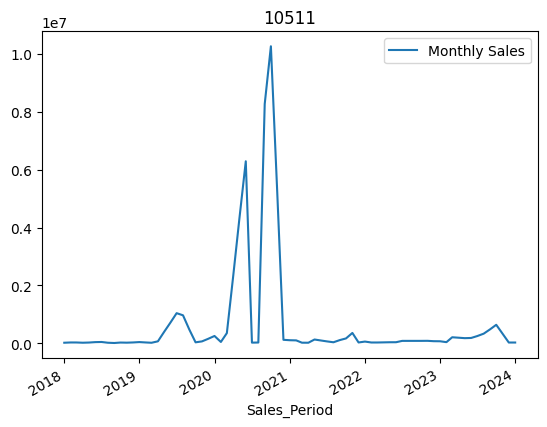

In [13]:
import pandas as pd
unique_rids = df['RID'].unique()
id = random.choice(unique_rids)
id = 10511
print(id)
tmp = df[df['RID'] == id].copy()
tmp['Monthly Sales'] = tmp['Monthly Sales'].interpolate(method='cubic')
tmp['Sales_Period'] = pd.to_datetime(tmp[['YEAR','MONTH']].assign(DAY=1))
generated_df = tmp[tmp['original'] == 0]
actual_df = tmp[tmp['original'] == 1]
display(tmp['Monthly Sales'].median())
display(tmp.describe())
display(actual_df['Monthly Sales'])
tmp.plot(title=id,x='Sales_Period',y='Monthly Sales')